In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

In [5]:
Data = pd.read_csv("Downloads/Data.europe.eu/estat_isoc_ec_eseln2_en.csv")

Data.head(5)

,DATAFLOW,LAST UPDATE,freq,size_emp,nace_r2,indic_is,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,AT,2011,46.37,NaN,NaN
1,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BE,2011,30.23,NaN,NaN
2,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BE,2013,10.91,NaN,NaN
3,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BG,2011,3.73,NaN,NaN
4,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BG,2013,4.57,NaN,NaN


In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761535 entries, 0 to 761534
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   DATAFLOW     761535 non-null  object 
 1   LAST UPDATE  761535 non-null  object 
 2   freq         761535 non-null  object 
 3   size_emp     761535 non-null  object 
 4   nace_r2      761535 non-null  object 
 5   indic_is     761535 non-null  object 
 6   unit         761535 non-null  object 
 7   geo          761535 non-null  object 
 8   TIME_PERIOD  761535 non-null  int64  
 9   OBS_VALUE    641685 non-null  float64
 10  OBS_FLAG     100557 non-null  object 
 11  CONF_STATUS  23713 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 69.7+ MB


In [7]:
Data.describe()

,TIME_PERIOD,OBS_VALUE
count,761535.000000,641685.000000
mean,2019.161641,28.963765
std,3.882851,30.563166
min,2009.000000,0.000000
25%,2017.000000,5.420000
50%,2020.000000,15.760000
75%,2022.000000,45.000000
max,2024.000000,102.160000


In [8]:
Data.shape

(761535, 12)

In [9]:
Data.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
size_emp        object
nace_r2         object
indic_is        object
unit            object
geo             object
TIME_PERIOD      int64
OBS_VALUE      float64
OBS_FLAG        object
CONF_STATUS     object
dtype: object

In [10]:
Data.reset_index(drop=True, inplace=True)

In [11]:
Data.isna().sum()

DATAFLOW            0
LAST UPDATE         0
freq                0
size_emp            0
nace_r2             0
indic_is            0
unit                0
geo                 0
TIME_PERIOD         0
OBS_VALUE      119850
OBS_FLAG       660978
CONF_STATUS    737822
dtype: int64

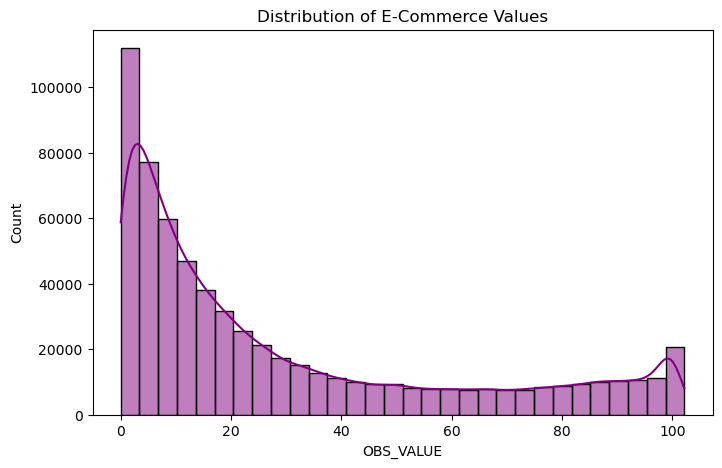

In [12]:
DF = Data[["freq", "size_emp", "nace_r2", "indic_is", "unit", "geo", "TIME_PERIOD", "OBS_VALUE"]]

plt.figure(figsize=(8,5))
sns.histplot(DF["OBS_VALUE"], bins=30, kde=True, color="purple")
plt.title("Distribution of E-Commerce Values")
plt.show()

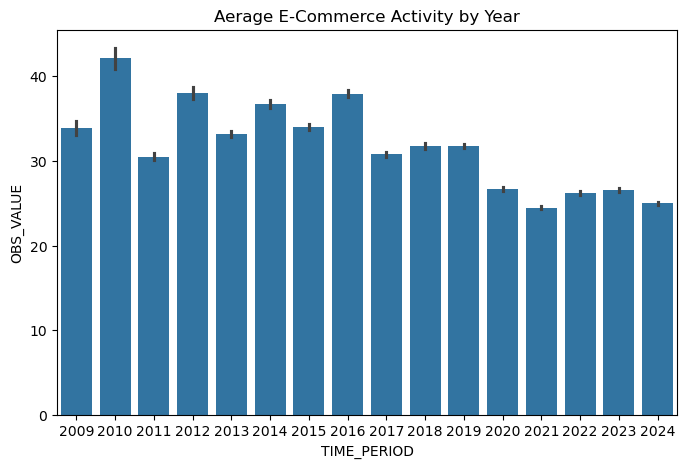

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(x="TIME_PERIOD", y="OBS_VALUE", data=DF, estimator=np.mean)
plt.title("Aerage E-Commerce Activity by Year")
plt.show()

In [14]:

TARGET = "OBS_VALUE"
DF = Data[["freq","size_emp","nace_r2","indic_is","unit","geo","TIME_PERIOD","OBS_VALUE"]].copy()
DF = DF.dropna(subset=[TARGET])

DF["year_bucket"] = (DF["TIME_PERIOD"] // 5) * 5


X = DF.drop(columns=[TARGET])
y = DF[TARGET]

num_cols = [c for c in X.columns if X[c].dtype.kind in "fcbi"]     
cat_cols = [c for c in X.columns if c not in num_cols]             
print(f"num:{len(num_cols)} | cat:{len(cat_cols)}")

num:2 | cat:6


In [19]:
CV = KFold(n_splits=3, shuffle=True, random_state=42)

LR = Pipeline(steps=[("pre", pre_linear), ("model", LinearRegression())])
RF = Pipeline(steps=[("pre", pre_tree),   ("model", RandomForestRegressor(
    n_estimators=200, n_jobs=-1, random_state=42
))])
GB = Pipeline(steps=[("pre", pre_tree),   ("model", GradientBoostingRegressor(
    random_state=42
))])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
def cv_rmse(model, X, y, cv=CV):
    s = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    return -s.mean(), s.std()

models = {"LinearRegression": LR, "RandomForest": RF, "GradientBoosting": GB}
rows = []
for name, mdl in models.items():
    m, sd = cv_rmse(mdl, X_train, y_train)
    rows.append([name, m, sd])
    print(f"{name:>16s} | CV RMSE: {m:.4f} ± {sd:.4f}")

LinearRegression | CV RMSE: 16.8618 ± 0.0018


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

rf_dist = {
    "model__n_estimators": randint(150, 400),
    "model__max_depth": randint(6, 20),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", 0.6, 0.8],
    "model__bootstrap": [True],
}
GS_RF = RandomizedSearchCV(
    estimator=RF,
    param_distributions=rf_dist,
    n_iter=25,                         
    scoring="neg_root_mean_squared_error",
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

gb_dist = {
    "model__learning_rate": uniform(0.03, 0.15),
    "model__n_estimators": randint(100, 350),
    "model__max_depth": randint(2, 5),
    "model__subsample": uniform(0.7, 0.3)    # 0.7–1.0
}
GS_GB = RandomizedSearchCV(
    estimator=GB,
    param_distributions=gb_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)


GS_RF.fit(X_train, y_train)
print("RF best params:", GS_RF.best_params_, "CV RMSE:", -GS_RF.best_score_)

GS_GB.fit(X_train, y_train)
print("GB best params:", GS_GB.best_params_, "CV RMSE:", -GS_GB.best_score_)

In [ ]:
def evaluate_model(name, y_true, y_pred):
    R2 = r2_score(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAE = mean_absolute_error(y_true, y_pred)
    print(f"{name}: R2 = {R2:.3f}, RMSE = {RMSE:.3f}, MAE = {MAE:.3f}")

print("......Baseline Model performance.....")

evaluate_model("Linear Regression", y_test, LR_Pred)
evaluate_model("Random Forest", y_test, RF_Pred)
evaluate_model("Gradient Boosting", y_test, GB_Pred)

In [ ]:

RF_Pred_Tuned = GS_RF.predict(X_test)
GB_Pred_Tuned = GS_GB.predict(X_test)

print("=== Tuned Models (Hold-out Test Performance) ===\n")
evaluate_model("Random Forest (tuned)", y_test, RF_Pred_Tuned)
evaluate_model("Gradient Boosting (tuned)", y_test, GB_Pred_Tuned)


RMSE_RF = np.sqrt(mean_squared_error(y_test, RF_Pred_Tuned))
RMSE_GB = np.sqrt(mean_squared_error(y_test, GB_Pred_Tuned))

if RMSE_RF <= RMSE_GB:
    Best_grid_name = "Random Forest (tuned)"
    Best_grid = GS_RF
else:
    Best_grid_name = "Gradient Boosting (tuned)"
    Best_grid = GS_GB

print("\n✅ Best tuned model:", Best_grid_name)


In [ ]:
y_Pred_Best = best_grid.predict(X_test)
residuals = y_test - y_pred_best


plt.figure(figsize=(8,4))
plt.scatter(y_pred_best, residuals, s=15, color="teal", alpha=0.6)
plt.axhline(0, ls="--", color="red")
plt.title(f"Residuals vs Predicted ({best_grid_name})")
plt.xlabel("Predicted OBS_VALUE")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40, color="orange", alpha=0.7)
plt.title(f"Residual Distribution ({best_grid_name})")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

print(f"Mean of residuals     : {residuals.mean():.4f}")
print(f"Std deviation residual: {residuals.std():.4f}")
print(f"Min residual          : {residuals.min():.4f}")
print(f"Max residual          : {residuals.max():.4f}")
